In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from scipy import signal
import numpy as np
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt

# Declare Model

In [2]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=80, n_channel=32):
        super(FIRNN, self).__init__()        
        self.conv_kz = kernel_size
        self.input_len = 512
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=kernel_size, stride=1)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=1) 
        self.fc2 = nn.Conv1d(n_channel*2, n_channel, kernel_size=1)
        
        self.conv2 = nn.Conv1d(n_channel, n_output, kernel_size=kernel_size, stride=1)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
        )


    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
        
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x)
        x1 = x
        #print(x.shape) #bs*32*512
        
        x = self.nonlinear(self.bn1(x))
        #print(x.shape) # bs*32*512
        x2 = x

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape) #bs*32*512
        x3 = x
        
        x = F.pad(x, (self.conv_kz-1, 0))
        x = self.conv2(x)
        #print(x.shape) #bs*1*512

        return x, x1, x2, x3


In [40]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)

    

# Load Model

In [41]:
model = FIRNN(kernel_size=80, n_channel=32)

In [42]:
model_path = './models/model_firnl_mlp_fir_preamph_ep99.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FIRNN(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(1,))
  (nonlinear): Tanh()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (fc2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(32, 1, kernel_size=(80,), stride=(1,))
  (mlp_layer): Sequential(
    (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  )
)

In [130]:
model.conv2.weight.shape

torch.Size([1, 32, 80])

## Plot waveform/ before and after mlp layer

In [43]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [44]:
out_path = './output/target_firnl_mlp_fir_preamph.wav'
distort_sig, _ = torchaudio.load(out_path)

In [67]:
train_input_seg = train_sig[:,:44100*60]
train_target_seg = train_target_sig[:,:44100*60]
distort_seg = distort_sig[:,:44100*60]

In [68]:
val_dataset=DIIRDataSet(train_input_seg.squeeze(0), train_target_seg.squeeze(0), 512)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

5167
torch.Size([5167, 1, 512])
5167
torch.Size([5167, 1, 512])


In [69]:
def save_audio(batch):
    #1024,512,1
    out_batch = batch.detach().cpu()
    out_batch = out_batch.squeeze(-1).flatten()
    print(out_batch.shape)
    return out_batch

In [70]:
import soundfile as sf
sample_rate = 44100
save_tensor = torch.zeros(5167,512)
conv1_tensor = torch.zeros(5167,512)
bfmlp_tensor = torch.zeros(5167,512)
afmlp_tensor = torch.zeros(5167,512)
out_path = './output/'

with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input']
        predicted_output, x1, x2, x3 = model(input_seq_batch)
        conv1_out = x1.detach().cpu()
        #print(conv1_out.shape) #1*32*512
        bfmlp_input = x2.detach().cpu()
        afmlp_out = x3.detach().cpu()
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp
        conv1_tensor[i,:] = torch.mean(conv1_out, 1)
        bfmlp_tensor[i,:] = torch.mean(bfmlp_input, 1)
        afmlp_tensor[i,:] = torch.mean(afmlp_out, 1)
    
    conv1_audio = save_audio(conv1_tensor)
    bfmlp_audio = save_audio(bfmlp_tensor)
    afmlp_audio = save_audio(afmlp_tensor)
    out_audio = save_audio(save_tensor)
    
    #print(conv1_audio.shape)
    #print(out_audio.shape)
    #path = os.path.join(out_path, "FIRNN_HT1_.wav")
    #print("Exporting {}".format(path))
    sf.write(os.path.join(out_path, 'FIRNN_HT1_conv1.wav'), conv1_audio, sample_rate,'PCM_24')
    sf.write(os.path.join(out_path, 'FIRNN_HT1_bfmlp.wav'), bfmlp_audio, sample_rate,'PCM_24')
    sf.write(os.path.join(out_path, 'FIRNN_HT1_afmlp.wav'), afmlp_audio, sample_rate,'PCM_24')
    sf.write(os.path.join(out_path, 'FIRNN_HT1_output.wav'), out_audio, sample_rate,'PCM_24')
    #torchaudio.save(path, out_audio, sample_rate, encoding="PCM_S", bits_per_sample=16)
   

torch.Size([2645504])
torch.Size([2645504])
torch.Size([2645504])
torch.Size([2645504])


In [71]:
conv1_sig, sr = torchaudio.load(os.path.join(out_path, 'FIRNN_HT1_conv1.wav'))
bfmlp_sig, _ = torchaudio.load(os.path.join(out_path, 'FIRNN_HT1_bfmlp.wav'))
afmlp_sig, _ = torchaudio.load(os.path.join(out_path, 'FIRNN_HT1_afmlp.wav'))
out_sig, _ = torchaudio.load(os.path.join(out_path, 'FIRNN_HT1_output.wav'))

In [72]:
s = conv1_sig

In [73]:
s.shape

torch.Size([1, 2645504])

In [74]:
def plot_waveform(waveform, sample_rate, title="Waveform of HT-1 distorted signal", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ylabel('Amplitude', fontsize=18)
    xlabel('Time', fontsize=18)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    #plt.savefig('./figures/'+title+'.png', dpi=150)
    plt.show(block=False)



In [116]:
def plot_waveform_spectrum(waveform, sample_rate, title="Waveform and Spectrum of HT-1 distorted signal", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    plt.figure(figsize=(15,4))

    # plot different spectrum types:
    plt.subplot(1,3,1)
    plt.title("Waveform", fontsize=18)
    plt.plot(time_axis, waveform[0], linewidth=1)
    plt.grid(alpha=0.4)
    plt.ylabel('Amplitude', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.ylim(-1.0, 1.0)

    plt.subplot(1,3,2)
    plt.title("Magnitude Spectrum", fontsize=18)
    plt.magnitude_spectrum(waveform[0], Fs=sample_rate, color='C1')
    plt.ylabel('Magnitude\n (energy)', fontsize=18)
    plt.xlabel(r'Frequency', fontsize=18)
    plt.ylim(0.000, 0.035)


    plt.subplot(1,3,3)
    plt.title("Spectrum", fontsize=18)
    plt.magnitude_spectrum(waveform[0], Fs=sample_rate, scale='dB', color='C1')
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=18)
    plt.xlabel(r'Frequency', fontsize=18)
    plt.ylim(-200, -50)

    plt.tight_layout()
    subplots_adjust(wspace=0.3)
    plt.tight_layout()
    #plt.savefig('./figures/conv1_output.png', dpi=150)
    plt.show()


In [ ]:
plot_waveform(s, sr, title="Waveform of conv1")

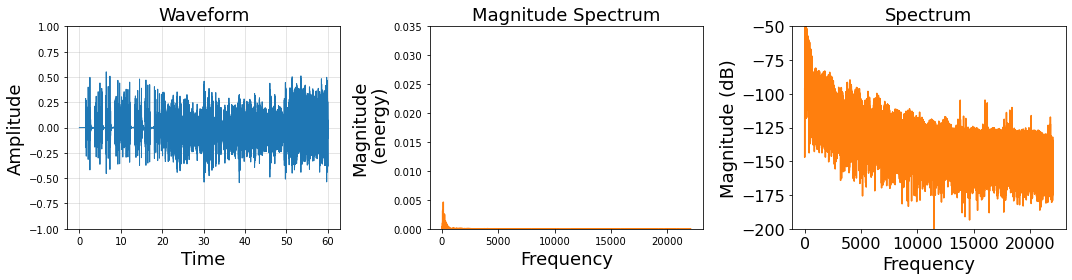

In [117]:
plot_waveform_spectrum(train_input_seg, sr, title="Waveform of input")

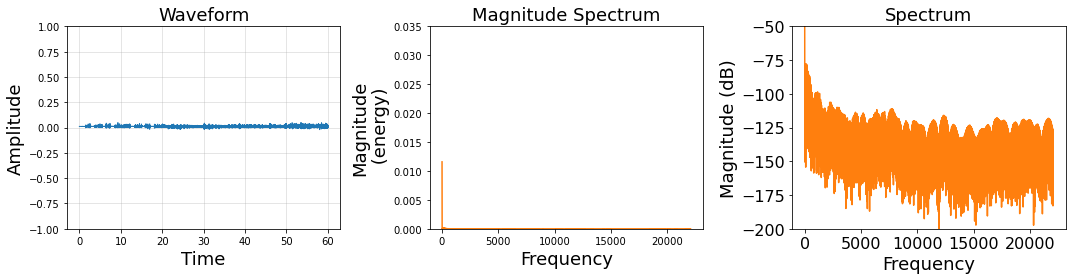

In [118]:
plot_waveform_spectrum(conv1_sig, sr, title="Waveform of conv1")

In [119]:
s2 = bfmlp_sig

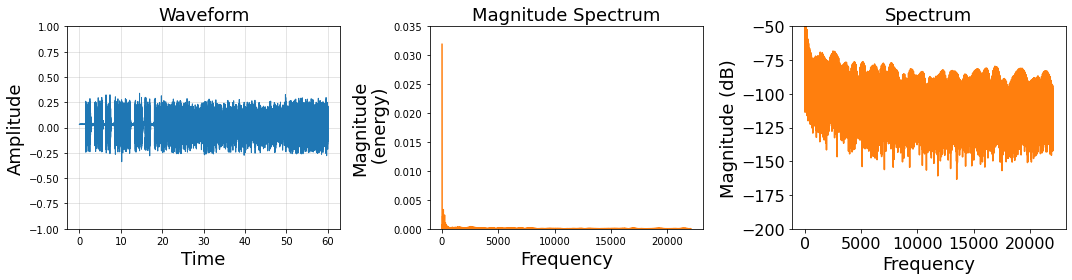

In [120]:
plot_waveform_spectrum(s2, sr, title="Waveform before MLP layer")
#plot_waveform(s2, sr, title="Waveform of before MLP layer")

In [121]:
s3 = afmlp_sig

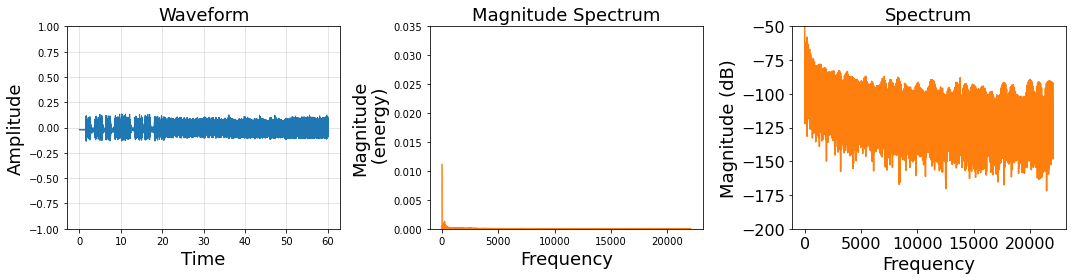

In [122]:
plot_waveform_spectrum(s3, sr, title="Waveform after MLP layer")
#plot_waveform(s3, sr, title="Waveform of after MLP layer")

In [123]:
s4 = out_sig

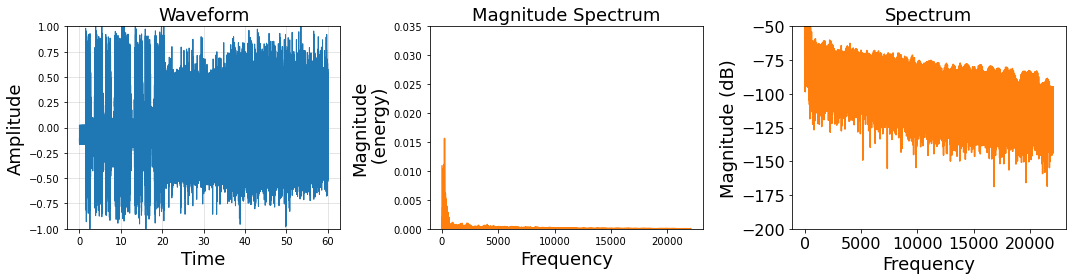

In [126]:
plot_waveform_spectrum(out_sig, sr, title="Waveform of the final output")

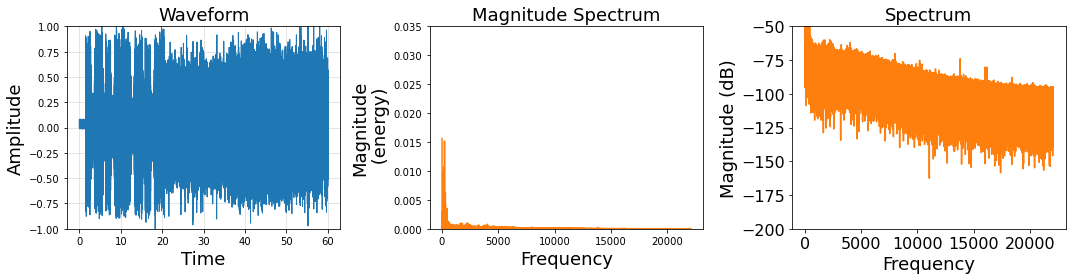

In [125]:
plot_waveform_spectrum(distort_seg, sr, title="Waveform of the final output")
#plot_waveform(s4, sr, title="Waveform of the final output")

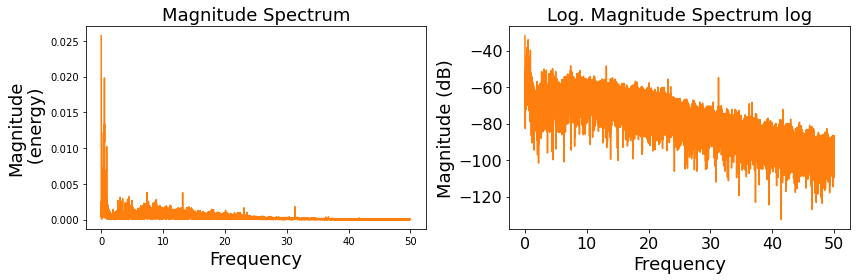

In [206]:
# plot time signal:
plt.figure(figsize=(12,4))
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# plot different spectrum types:
plt.subplot(1,2,1)
title("Magnitude Spectrum", fontsize=18)
plt.magnitude_spectrum(s, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n (energy)', fontsize=18)
plt.xlabel(r'Frequency', fontsize=18)

plt.subplot(1,2,2)
title("Log. Magnitude Spectrum log", fontsize=18)
plt.magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel(r'Frequency', fontsize=18)

fig.tight_layout()
subplots_adjust(wspace=0.3)
plt.tight_layout()
#plt.savefig('./figures/firnn_spectrum.png', dpi=150)
plt.show()

## Test on a sinusoidal signal

In [12]:
np.random.seed(0)
f = 1245

#dt = 0.01/f  # sampling interval
Fs = f*10 #1 / dt  # sampling frequency
dt = 1/Fs
t = np.arange(0, 200, dt)

len(t)

dt

# generate noise:
# nse = np.random.randn(len(t))
# r = np.exp(-t / 0.05)
# cnse = np.convolve(nse, r) * dt
# cnse = cnse[:len(t)]

#s = 0.1 * np.sin(4 * np.pi * t) + cnse  # the signal

s = np.sin(2 * np.pi * f * t)

Fs

plt.plot(t,s)
plt.xlim(0,0.01)
plt.show()

In [13]:
sinput = torch.from_numpy(s).unsqueeze(0)

In [14]:
sinput.shape

torch.Size([1, 2490000])

In [15]:
val_dataset=DIIRDataSet(sinput.squeeze(0), sinput.squeeze(0), 512)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

4863
torch.Size([4863, 1, 512])
4863
torch.Size([4863, 1, 512])


In [16]:
save_tensor = torch.zeros(4863,512)
with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input']
        predicted_output = model(input_seq_batch)
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp

In [54]:
save_tensor[0,:5]

tensor([-0.1112,  0.0553,  0.0141,  0.0007,  0.2454])

In [55]:
save_tensor[1,:5]

tensor([ 0.1177, -0.0384, -0.2748,  0.1993,  0.2213])

In [56]:
save_tensor.view(-1)

tensor([-0.1112,  0.0553,  0.0141,  ..., -0.0969, -0.0208,  0.0802])

In [17]:
soutput = save_tensor.view(-1).numpy()#[0].numpy()#

In [18]:
soutput.shape

(2489856,)

## plot spectrum of the output from the model of a sinusoidal signal

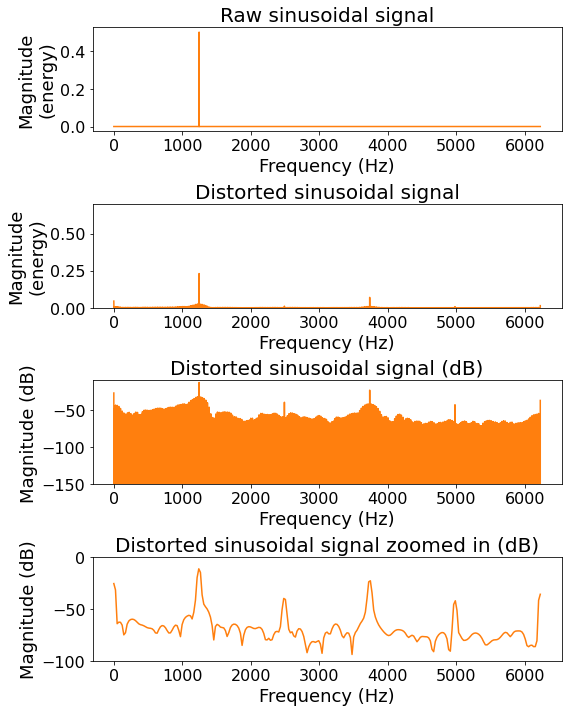

In [25]:
plt.figure(figsize=(8,10))
plt.subplot(4,1,1)
title("Raw sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(s, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(4,1,2)
title("Distorted sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(soutput, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0.0, 0.7)

plt.subplot(4,1,3)
title("Distorted sinusoidal signal (dB)", fontsize=20)
plt.magnitude_spectrum(soutput, Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-150, -10)

plt.subplot(4,1,4)
title("Distorted sinusoidal signal zoomed in (dB)", fontsize=20)
plt.magnitude_spectrum(soutput[:512], Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-100,0)

plt.tight_layout()
subplots_adjust(hspace=0.7)
#plt.savefig('./figures/FIRNN_sin_signal_spectrums.png', dpi=150)
plt.show()

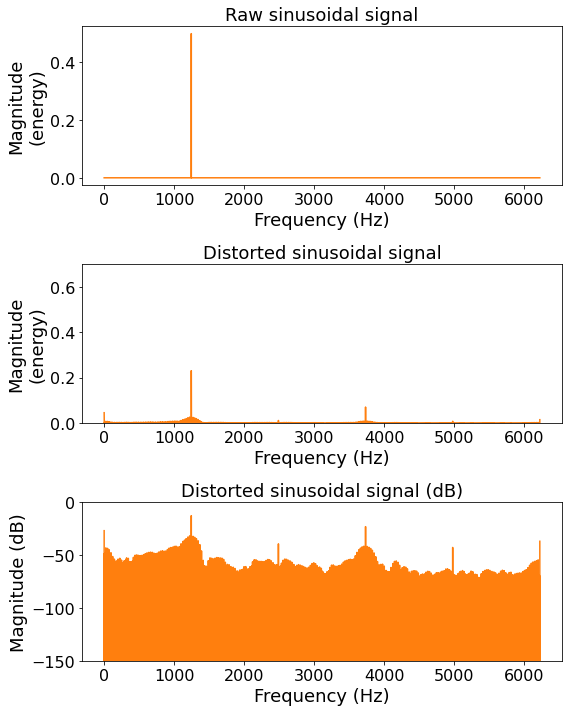

In [29]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
title("Raw sinusoidal signal", fontsize=18)
plt.magnitude_spectrum(s, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(3,1,2)
title("Distorted sinusoidal signal", fontsize=18)
plt.magnitude_spectrum(soutput, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0.0, 0.7)

plt.subplot(3,1,3)
title("Distorted sinusoidal signal (dB)", fontsize=18)
plt.magnitude_spectrum(soutput, Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-150, 0)

plt.tight_layout()
subplots_adjust(hspace=0.5)
plt.savefig('./figures/FIRNN_sin_signal_spectrums.png', dpi=150)
plt.show()

### Get the convolution layer weights & average across channel dim

In [125]:
fir_weights = model.conv1.weight.detach().cpu().squeeze(1).numpy()
fir_coefs = np.mean(fir_weights,0)

In [126]:
fir_coefs

array([-0.01222002,  0.00816907, -0.01958346, -0.00557637, -0.00838309,
        0.00740024,  0.00224737,  0.00358305, -0.01717601, -0.00658894,
       -0.01649614,  0.00532944,  0.02984523,  0.00186908, -0.02407964,
        0.00138048,  0.00955625,  0.01877122, -0.01838095,  0.00603837,
       -0.00176823, -0.01194985,  0.0091839 ,  0.01315025,  0.00886461,
       -0.0030168 ,  0.0055296 , -0.01162905,  0.00081922,  0.01366433,
       -0.00379462,  0.0173795 , -0.00161399,  0.01072577,  0.01400186,
       -0.0104241 , -0.00512943, -0.01274905,  0.0238186 , -0.0049278 ,
        0.01628523, -0.01408131, -0.0179005 ,  0.00271774, -0.00335456,
        0.00653065,  0.00435312, -0.01464136, -0.00332784, -0.02269191,
        0.00308686,  0.01414565,  0.01356323, -0.01500301,  0.00448944,
       -0.00359043,  0.03537583, -0.03113224,  0.02900903, -0.0047919 ,
       -0.00904516,  0.00472102,  0.00436347,  0.00434088, -0.01016037,
       -0.00475422,  0.00726954,  0.00212752, -0.00717166,  0.02

In [61]:
np.flip(fir_coefs)

array([ 0.02461519, -0.02216252, -0.03035861,  0.00867285, -0.0123441 ,
        0.02031838,  0.00221973, -0.00479159,  0.00677762, -0.00700613,
        0.0265362 , -0.00717166,  0.00212752,  0.00726954, -0.00475422,
       -0.01016037,  0.00434088,  0.00436347,  0.00472102, -0.00904516,
       -0.0047919 ,  0.02900903, -0.03113224,  0.03537583, -0.00359043,
        0.00448944, -0.01500301,  0.01356323,  0.01414565,  0.00308686,
       -0.02269191, -0.00332784, -0.01464136,  0.00435312,  0.00653065,
       -0.00335456,  0.00271774, -0.0179005 , -0.01408131,  0.01628523,
       -0.0049278 ,  0.0238186 , -0.01274905, -0.00512943, -0.0104241 ,
        0.01400186,  0.01072577, -0.00161399,  0.0173795 , -0.00379462,
        0.01366433,  0.00081922, -0.01162905,  0.0055296 , -0.0030168 ,
        0.00886461,  0.01315025,  0.0091839 , -0.01194985, -0.00176823,
        0.00603837, -0.01838095,  0.01877122,  0.00955625,  0.00138048,
       -0.02407964,  0.00186908,  0.02984523,  0.00532944, -0.01

# Plot frequency response of the first "FIR" filter

In [136]:
def freq_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    #print(len(w))
    h_dB = 20 * np.log10 (abs(h))
   
    #plt.plot(w/max(w), h_dB, linewidth=2)
    plt.plot((w/np.pi)*nyq_rate,h_dB, linewidth=2)
    plt.xlabel('Frequency (Hz)', fontsize=18)
    plt.ylabel('Gain (dB)', fontsize=18)
    plt.title('Frequency Response', fontsize=20)
    plt.ylim(-80, 20)
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/firnn_Frequency_response_1conv.png', dpi=150)
    plt.show()

def phase_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    plt.plot((w/np.pi)*nyq_rate,h_Phase, c='orange')
    plt.ylabel('Phase (radians)', fontsize=18)
    plt.xlabel(r'Frequency (Hz)', fontsize=18)
    plt.title(r'Phase response', fontsize=20)
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/firnn_Phase_response_1conv.png', dpi=150)
    plt.show()


In [137]:
#Plot step and impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,1,impulse)
    plt.stem(x, response)
    plt.grid(alpha=0.4)
    ylabel('Amplitude', fontsize=18)
    xlabel(r'n (samples)', fontsize=18)
    title(r'Impulse response', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/firnn_impulse_response_1conv.png', dpi=150)

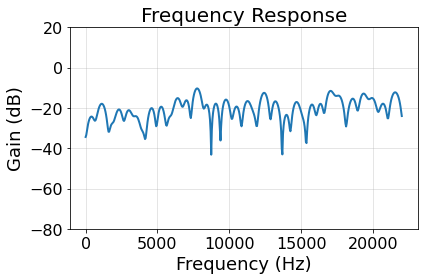

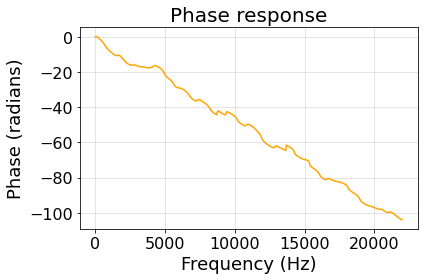

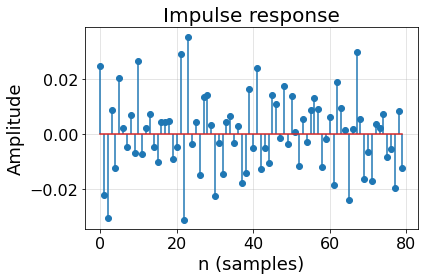

In [138]:
freq_plot(np.flip(fir_coefs))
phase_plot(np.flip(fir_coefs))
impz(np.flip(fir_coefs))

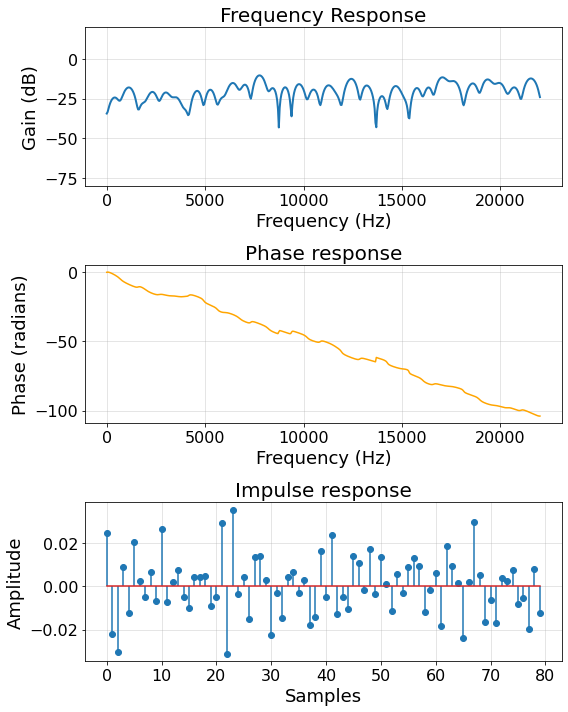

In [129]:
b = np.flip(fir_coefs)
a = 1
w,h = signal.freqz(b,a)
nyq_rate = 44100/2
h_dB = 20 * np.log10 (abs(h))
h_Phase = unwrap(arctan2(imag(h),real(h)))


plt.figure(figsize=(8,10))

plt.subplot(3,1,1)
#plt.plot(w/max(w), h_dB, linewidth=2)
plt.plot((w/np.pi)*nyq_rate,h_dB, linewidth=2)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Gain (dB)', fontsize=18)
plt.title('Frequency Response', fontsize=20)
plt.ylim(-80, 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
#plt.savefig('Frequency_response_1conv.png', dpi=150)

plt.subplot(3,1,2)
#plt.plot(w/max(w), h_Phase, c='orange')
plt.plot((w/np.pi)*nyq_rate,h_Phase, c='orange')
plt.ylabel('Phase (radians)', fontsize=18)
plt.xlabel(r'Frequency (Hz)', fontsize=18)
plt.title(r'Phase response', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
#plt.savefig('Phase_response_1conv.png', dpi=150)


l = len(b)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = signal.lfilter(b,1,impulse)
plt.subplot(3,1,3)
plt.stem(x, response)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel(r'Samples', fontsize=18)
plt.title(r'Impulse response', fontsize=20)
#plt.savefig('impulse_response_1conv.png', dpi=150)

plt.tight_layout()
subplots_adjust(hspace=0.5)
plt.savefig('./figures/FIRNN_freqresp_ph_imp_(ord80).png', dpi=150)
plt.show()

## Import input & output audios

In [67]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cpu


In [68]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [69]:
train_input_seg = train_sig[:,:44100*60]
train_target_seg = train_target_sig[:,:44100*60]

In [71]:
out_path = './output/target_FIRNN_HT1_nobias.wav'
#target_firnl_mlp_fir_preamph.wav
distort_sig, _ = torchaudio.load(out_path)

## Plot spectrum, waveform

In [72]:
def plot_waveform(waveform, sample_rate, title="Waveform of HT-1 distorted signal", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    ylabel('Amplitude')
    xlabel('time (s)')
    plt.grid(alpha=0.4)
    #plt.savefig('Waveform_of_target.png', dpi=150)
    plt.show(block=False)



In [73]:
def plot_specgram(waveform, sample_rate, title="Spectrogram of HT-1 distorted Signal", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    figure.suptitle(title)
    ylabel('Frequency')
    xlabel('time (s)')
    #plt.savefig('Specgram_of_target.png', dpi=150)
    plt.show(block=False)

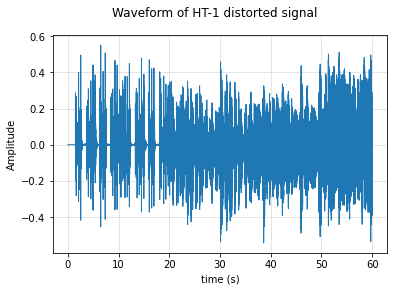

In [74]:
plot_waveform(train_input_seg, sr)

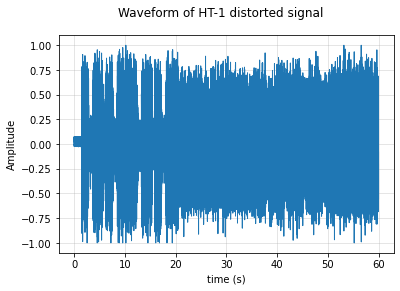

In [75]:
plot_waveform(distort_sig, sr)

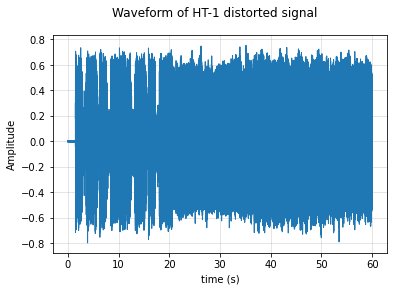

In [76]:
plot_waveform(train_target_seg, sr)

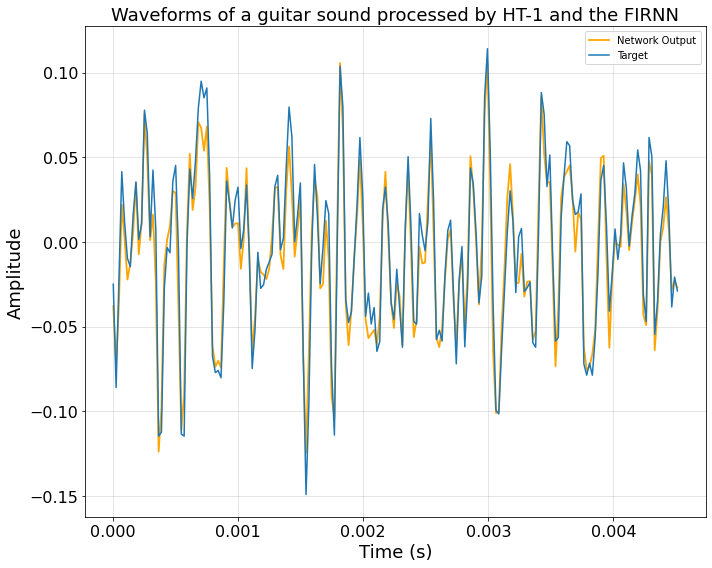

In [142]:
nn_out = distort_sig.squeeze()[44100*3:44100*3+200].numpy()
target = train_target_seg.squeeze()[44100*3:44100*3+200].numpy()

sample_rate = 44100

num_frames = nn_out.shape[0]
time_axis = np.arange(0, num_frames) / sample_rate

plt.figure(figsize=(10,8))
plt.plot(time_axis, nn_out, c='orange',linewidth=1.8)
plt.plot(time_axis, target,linewidth=1.5)
plt.grid(alpha=0.4)
ylabel('Amplitude', fontsize=18)
xlabel('Time (s)', fontsize=18)
title(r'Waveforms of a guitar sound processed by HT-1 and the FIRNN', fontsize=18)
legend(['Network Output', 'Target'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('./figures/waveform_cmp_nnout_target.png', dpi=150)

In [31]:
nn_out.shape[0]

50

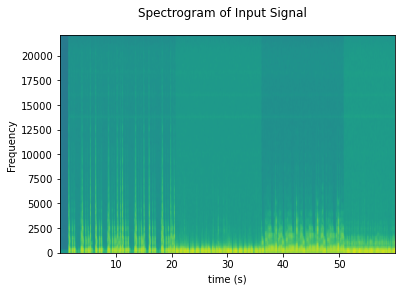

In [87]:
plot_specgram(train_input_seg, sr)


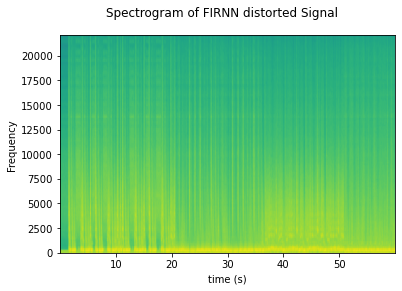

In [93]:
plot_specgram(distort_sig, sr)

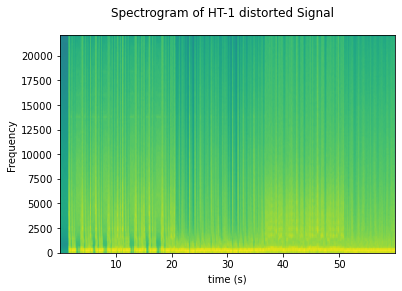

In [95]:
plot_specgram(train_target_seg, sr)


# Plot Spectrum (log) here

In [10]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [11]:
out_path = './output/target_firnl_mlp_fir_preamph.wav'
distort_sig, _ = torchaudio.load(out_path)

In [15]:
train_input_seg = train_sig[:,44100*3:44100*4].squeeze().numpy()
train_target_seg = train_target_sig[:,44100*3:44100*4].squeeze().numpy()
distort_seg = distort_sig[:,44100*3:44100*4].squeeze().numpy()

In [16]:
distort_seg.shape

(44100,)

In [17]:
Fs = 44100  # sampling frequency
dt = 1/Fs  # sampling interval
t = np.arange(0, 10, dt)

In [21]:
dt

2.2675736961451248e-05

In [20]:
len(t)

441000

In [31]:
s = train_input_seg

(array([2.56352453e-05, 1.80294849e-05, 2.87929649e-05, ...,
        8.73423829e-08, 1.90272172e-07, 3.07763026e-07]),
 array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.2048e+04, 2.2049e+04,
        2.2050e+04]),
 <matplotlib.lines.Line2D at 0x2ba4cdd531c0>)

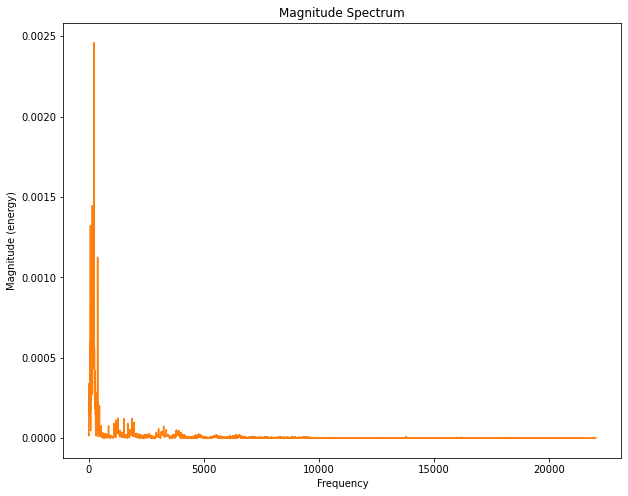

In [32]:
plt.figure(figsize=(10,8))
title("Magnitude Spectrum")
plt.magnitude_spectrum(s, Fs=Fs, color='C1')

(array([2.56352453e-05, 1.80294849e-05, 2.87929649e-05, ...,
        8.73423829e-08, 1.90272172e-07, 3.07763026e-07]),
 array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.2048e+04, 2.2049e+04,
        2.2050e+04]),
 <matplotlib.lines.Line2D at 0x2ba4cde3e250>)

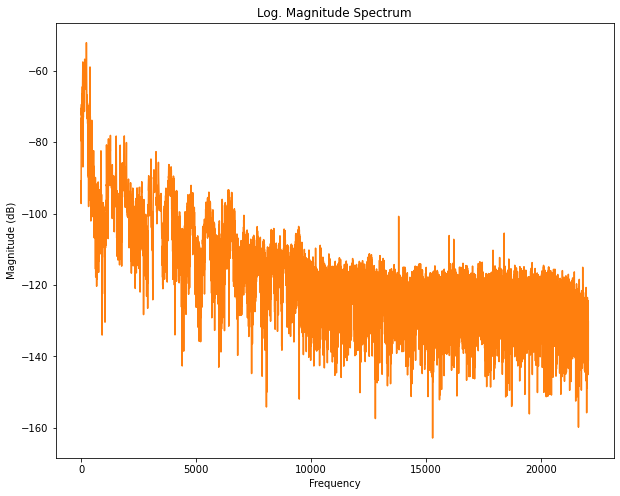

In [33]:
plt.figure(figsize=(10,8))
title("Log. Magnitude Spectrum")

plt.magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

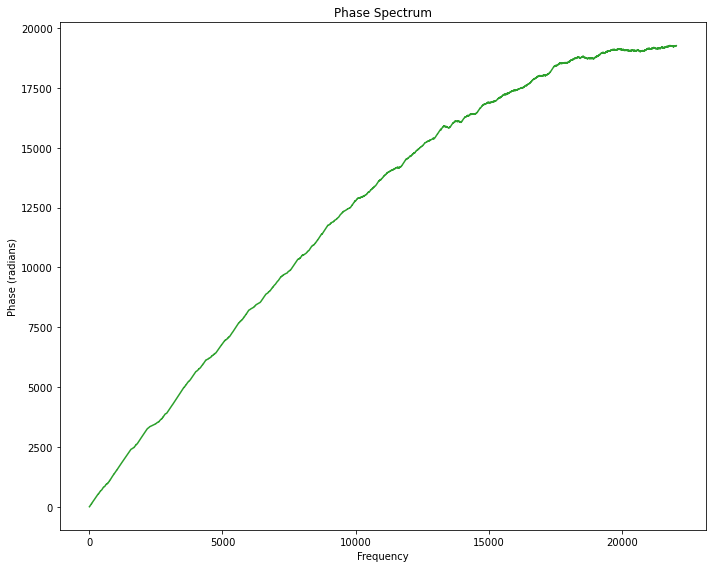

In [35]:
plt.figure(figsize=(10,8))
title("Phase Spectrum")

plt.phase_spectrum(s, Fs=Fs, color='C2')
plt.tight_layout()

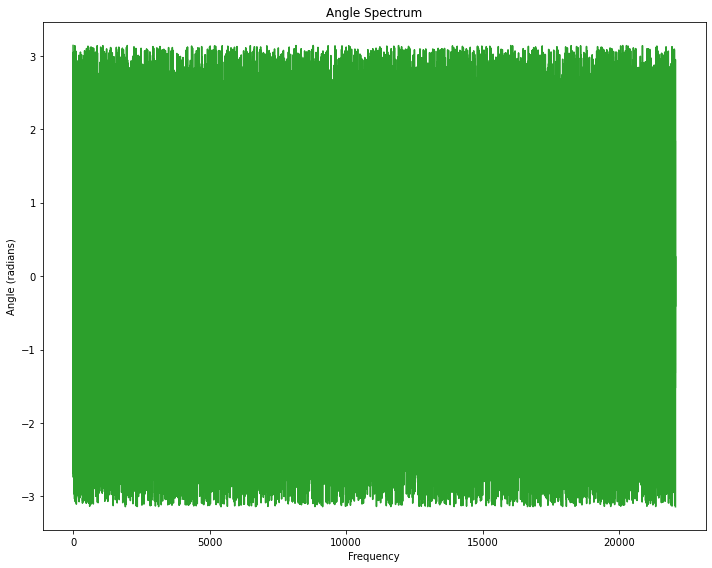

In [36]:
plt.figure(figsize=(10,8))
title("Angle Spectrum")

plt.angle_spectrum(s, Fs=Fs, color='C2')
plt.tight_layout()

In [42]:
s = train_target_seg

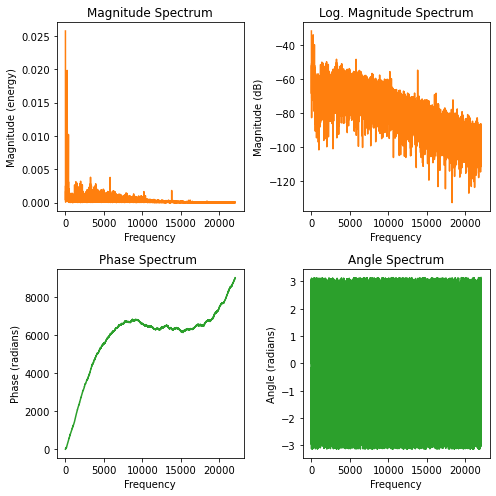

In [43]:
# plot time signal:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

# axs[0, 0].set_title("Signal")
# axs[0, 0].plot(t, s, color='C0')
# axs[0, 0].set_xlabel("Time")
# axs[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axs[0, 0].set_title("Magnitude Spectrum")
axs[0, 0].magnitude_spectrum(s, Fs=Fs, color='C1')

axs[0, 1].set_title("Log. Magnitude Spectrum")
axs[0, 1].magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

axs[1, 0].set_title("Phase Spectrum ")
axs[1, 0].phase_spectrum(s, Fs=Fs, color='C2')

axs[1, 1].set_title("Angle Spectrum")
axs[1, 1].angle_spectrum(s, Fs=Fs, color='C2')

#axs[0, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.savefig('firnn_spectrum_1s.png', dpi=150)
plt.show()

In [52]:
s = train_input_seg

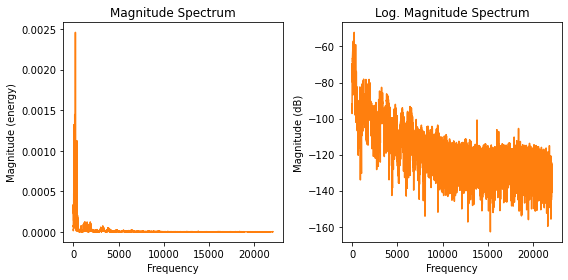

In [53]:
# plot time signal:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# axs[0, 0].set_title("Signal")
# axs[0, 0].plot(t, s, color='C0')
# axs[0, 0].set_xlabel("Time")
# axs[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axs[0].set_title("Magnitude Spectrum")
axs[0].magnitude_spectrum(s, Fs=Fs, color='C1')

axs[1].set_title("Log. Magnitude Spectrum")
axs[1].magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

# axs[1, 0].set_title("Phase Spectrum ")
# axs[1, 0].phase_spectrum(s, Fs=Fs, color='C2')

# axs[1, 1].set_title("Angle Spectrum")
# axs[1, 1].angle_spectrum(s, Fs=Fs, color='C2')

#axs[0, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.savefig('input_spectrum_1s.png', dpi=150)
plt.show()